In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns

invoice_df = pd.read_csv('data/invoice_train.csv')
client_df = pd.read_csv('data/client_train.csv')



# 1. New column (index_diff = new_index - old_index)
invoice_df['index_diff'] = invoice_df['new_index'] - invoice_df['old_index']

invoice_df['total_consumption'] = (
    invoice_df['consommation_level_1'].fillna(0) +
    invoice_df['consommation_level_2'].fillna(0) +
    invoice_df['consommation_level_3'].fillna(0) +
    invoice_df['consommation_level_4'].fillna(0)
)


# choose 5 columns
analysis_cols = ['consommation_level_1', 'consommation_level_2', 
                'consommation_level_3', 'consommation_level_4', 'index_diff', 'total_consumption']



/var/folders/t8/wfwm575525v6fcfsxf1vthj00000gn/T/ipykernel_2127/346403080.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  invoice_df = pd.read_csv('data/invoice_train.csv')


In [6]:
# 2. aggregating on client_id (min, max, std, mean)
aggregated_df = invoice_df.groupby('client_id')[analysis_cols].agg(['min', 'max', 'std', 'mean'])



In [ ]:
aggregated_df.columns = ['_'.join(col) for col in aggregated_df.columns]

# reset index 
aggregated_df = aggregated_df.reset_index()

final_df = aggregated_df.merge(client_df[['client_id', 'target']], on='client_id', how='inner')

In [8]:
final_df.to_csv('client_consumption_analysis.csv', index=False)

In [ ]:
from sklearn.feature_selection import mutual_info_classif


# selecting feature columns
feature_columns = [col for col in final_df.columns if col != 'target' and col != 'client_id']


# Check missing NaN
print("Missing value:")
print(final_df[feature_columns].isna().sum())




Missing value:
consommation_level_1_min        0
consommation_level_1_max        0
consommation_level_1_std     4212
consommation_level_1_mean       0
consommation_level_2_min        0
consommation_level_2_max        0
consommation_level_2_std     4212
consommation_level_2_mean       0
consommation_level_3_min        0
consommation_level_3_max        0
consommation_level_3_std     4212
consommation_level_3_mean       0
consommation_level_4_min        0
consommation_level_4_max        0
consommation_level_4_std     4212
consommation_level_4_mean       0
index_diff_min                  0
index_diff_max                  0
index_diff_std               4212
index_diff_mean                 0
total_consumption_min           0
total_consumption_max           0
total_consumption_std        4212
total_consumption_mean          0
dtype: int64


In [16]:
final_df[feature_columns] = final_df[feature_columns].fillna(0)

X = final_df[feature_columns]
y = final_df['target']

mi_scores = mutual_info_classif(X, y, random_state=50) 

In [17]:
mi_results = pd.DataFrame({
    'Feature': feature_columns,
    'MI_Score': mi_scores
})

In [18]:

mi_results = mi_results.sort_values('MI_Score', ascending=False).reset_index(drop=True)

print("\nMI score):")
print(mi_results)


MI score):
                      Feature  MI_Score
0              index_diff_max  0.010230
1       total_consumption_max  0.010000
2       total_consumption_std  0.009533
3              index_diff_std  0.009524
4    consommation_level_3_max  0.008549
5    consommation_level_2_max  0.008356
6   consommation_level_3_mean  0.008011
7   consommation_level_2_mean  0.007794
8    consommation_level_3_std  0.007610
9    consommation_level_1_max  0.007367
10   consommation_level_1_std  0.006969
11   consommation_level_2_std  0.006830
12   consommation_level_4_std  0.006588
13  consommation_level_4_mean  0.006152
14   consommation_level_4_max  0.006066
15     total_consumption_mean  0.006006
16            index_diff_mean  0.005457
17  consommation_level_1_mean  0.004546
18   consommation_level_1_min  0.004306
19      total_consumption_min  0.003455
20             index_diff_min  0.002742
21   consommation_level_2_min  0.000323
22   consommation_level_3_min  0.000187
23   consommation_level_4_mi

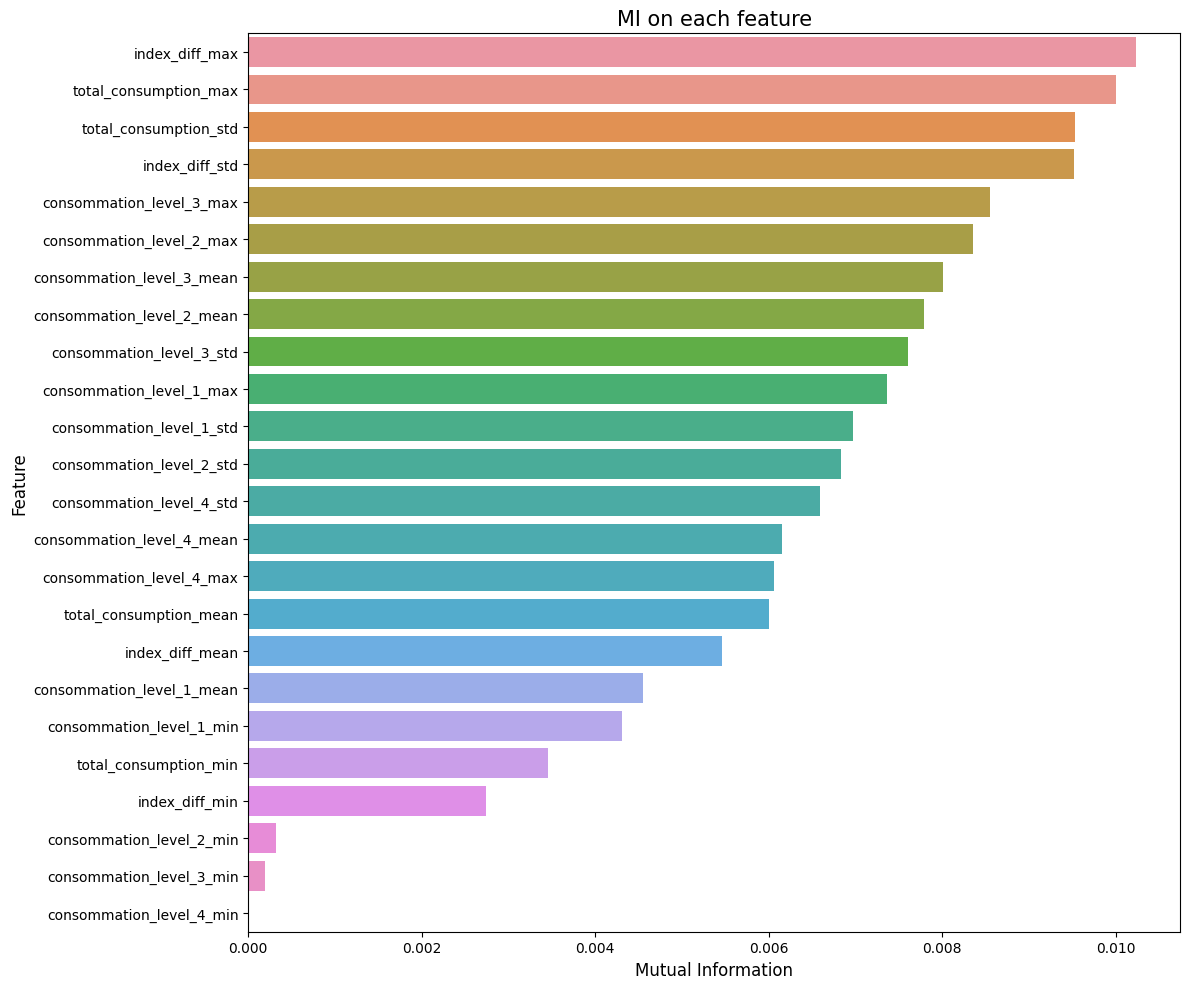

In [19]:
# Visualization
plt.figure(figsize=(12, 10))
sns.barplot(x='MI_Score', y='Feature', data=mi_results)
plt.title('MI on each feature', fontsize=15)
plt.xlabel('Mutual Information', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('mutual_info_barplot.png')
plt.show()